In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from joblib import delayed, Parallel

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0
from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
df = pd.read_csv('data/wuhan.csv', sep=',')
df['date'] = df['date'].apply(T)

In [4]:
### ATTENTION
# start and end date of date being  fitted
start_date = T('27/01/2020')  # T=0
end_date = T('09/02/2020')  #

In [5]:
subdf = df[(df['date'] > start_date) & (df['date'] < end_date)] 

I_true = subdf['infected'].values
O_true = subdf['death'].values + subdf['cured'].values

In [6]:
### ATTENTION
#  below is the number of new beds on  some days
#  it  is increment, not  total number
total_days = subdf.shape[0]
bed_info_raw = [
    (T('27/01/2020'), 4000),
    (T('31/01/2020'), 6000), # 10000),
    (T('04/02/2020'), 1000), # 11000),
    (T('07/02/2020'), 2000), # 13000)
    (T('11/02/2020'), 6000),  # 19000
    (T('17/02/2020'), 1000),  # 20000
]
# number of new beds at  some days
bed_info = [((d-start_date).days, n) for d, n in bed_info_raw if d < end_date]
bed_info

[(0, 4000), (4, 6000), (8, 1000), (11, 2000)]

In [8]:
from datetime import datetime
p0_time = datetime(2020, 1, 27)

In [9]:
#### ATTENTION
#  below are the parameter search ranges
alpha_list = np.arange(1.5,  1.61,  step=0.05) * 1e-08
beta_list = np.arange(1.5,  1.61,  step=0.05) * 1e-09

# assumption: alpha > beta
alpha_beta_choices = [
    (alpha,  beta)
    for alpha, beta in product(alpha_list, beta_list)
    if alpha > beta
] 
num_I_list = np.arange(5000, 10001, step=1000)
I2E_factors = [1., 1.5, 2]
I2M_factors = [0.25, 0.5, 1.0]

k_days_list = [28]

mu_ei_list = [6] 
mu_mo_list = [14]

def one_run(initial_num_I, I2E_factor, I2M_factor, alpha, beta, mu_ei, mu_mo, k_days):
    initial_num_E = initial_num_I * I2E_factor
    initial_num_M = initial_num_I * I2M_factor
    initial_num_M = min(bed_info[0][1], initial_num_M)
    
    params = Params(
        initial_num_I=initial_num_I,
        initial_num_E=initial_num_E,
        initial_num_M=initial_num_M,
        alpha=alpha,
        beta=beta,
        mu_ei=mu_ei,
        mu_mo=mu_mo,
        k_days=k_days,        
    )
    total, delta, increase, trans_data, ax = do_simulation(
        total_days, bed_info, params, p0_time=p0_time
    )
    
    I_mae = mean_absolute_error(I_true, increase[1:, STATE.I])
    O_mae = mean_absolute_error(O_true, increase[1:, STATE.O])

    
    I_mse = mean_squared_error(I_true, increase[1:, STATE.I])
    O_mse = mean_squared_error(O_true, increase[1:, STATE.O])

    row = (
        initial_num_I, initial_num_E, initial_num_M,
        alpha, beta, k_days, mu_ei, mu_mo,
        I_mae,  O_mae,  I_mse, O_mse
    )
    return row
    
total_num_configs = (
    len(num_I_list) 
    * len(alpha_beta_choices) 
    * len(I2E_factors) 
    * len(mu_ei_list) 
    * len(mu_mo_list) 
    * len(I2M_factors)
    * len(k_days_list)
)

rows = Parallel(n_jobs=-1)(
    delayed(one_run)(num_I, I2E_factor, I2M_factor, alpha, beta, mu_ei, mu_mo, k_days)
    for num_I, I2E_factor, I2M_factor, (alpha,  beta), mu_ei, mu_mo, k_days in tqdm(
        product(num_I_list, I2E_factors, I2M_factors, alpha_beta_choices, mu_ei_list, mu_mo_list, k_days_list), total=total_num_configs
    )
)



100%|██████████| 486/486 [00:35<00:00, 13.65it/s]


In [10]:
df = pd.DataFrame(
    rows,
    columns=['initial_num_I', 'initial_num_E', 'initial_num_M', 'alpha', 'beta',
             'k_days',
             'mu_ei', 'mu_mo',
             'I_mae', 'O_mae',  'I_mse', 'O_mse']
)

In [11]:
br = df.sort_values(by='I_mae').iloc[0]



  2%|▏         | 3/162 [00:00<00:05, 29.04it/s]

initial_num_I    6.000000e+03
initial_num_E    6.000000e+03
initial_num_M    4.000000e+03
alpha            1.600000e-08
beta             1.600000e-09
k_days           2.800000e+01
mu_ei            6.000000e+00
mu_mo            1.400000e+01
I_mae            2.935479e+02
O_mae            7.178060e+01
I_mse            1.136348e+05
O_mse            7.883753e+03
Name: 107, dtype: float64



 96%|█████████▌| 155/162 [00:31<00:01,  4.77it/s]

O fraction  0.9902159860540781


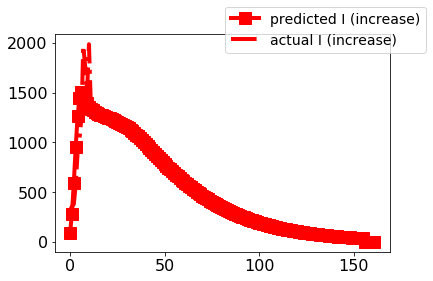

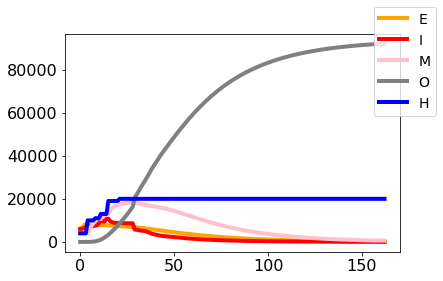

In [14]:
# number of new beds at  some days
bed_info = [((d-start_date).days, n) for d, n in bed_info_raw]
bed_info

print(br)

params = Params(
    initial_num_I=br.initial_num_I, 
    initial_num_E=br.initial_num_E,
    initial_num_M=br.initial_num_M,
    alpha=br.alpha, beta=br.beta,
    mu_ei=br.mu_ei, mu_mo=br.mu_mo,
    k_days=int(br.k_days)
)
total, delta, increase, trans_data, aux = do_simulation(total_days+150, bed_info, params, p0_time=p0_time)    

fig, ax = plt.subplots(1, 1)

ax.plot(increase[1:, STATE.I], 's-', color='red')
ax.plot(I_true, '-.', color='red')
fig.legend(['predicted I (increase)', 'actual I (increase)'])
fig.savefig('figs/true_I_vs_pred_I.pdf')

# fig, ax = plt.subplots(1, 1)

# ax.plot(increase[1:, STATE.O], 's-', color='red')
# ax.plot(O_true, '-.', color='red')
# fig.legend(['predicted O (increase)', 'actual O (increase)'])
# fig.savefig('figs/true_O_vs_pred_O.pdf')

fig, ax = plt.subplots(1, 1)
for color, s in zip(COLORS[1:], range(1, NUM_STATES)):
    ax.plot(total[:, s], c=color)
fig.legend(STATES[1:])
fig.savefig('figs/Jan27-final.pdf')

In [14]:
print(params)

total_population: 9000000
initial_num_E: 6000.0
initial_num_I: 6000.0
initial_num_M: 4000.0

alpha: 1.6e-08
beta:  1.6000000000000003e-09

mu_ei: 6.0

x0_pt: 10000
k_pt:  0.0001

mu_mo: 14.0

k_days: 28
        


In [15]:
pkl.dump(
    params,
    open('output/params_after_lockdown.pkl', 'wb')
)

In [18]:
bed_info = [((d-start_date).days, n) for d, n in bed_info_raw]

params = Params(
    initial_num_I=br.initial_num_I, 
    initial_num_E=br.initial_num_E,
    initial_num_M=br.initial_num_M,
    alpha=br.alpha, beta=br.beta,
    mu_ei=br.mu_ei, mu_mo=br.mu_mo,
    k_days=int(br.k_days)
)
_, _, _, R0_by_stage = do_simulation(30, bed_info, params)    

T1, T2, R0 = R0_by_stage[0]
print(f'T1={T1}, T2={T2}, R0={R0}')



100%|██████████| 30/30 [00:03<00:00,  7.56it/s]

T1=5.821102553833502, T2=5.637780575044747, R0=1.9874744179186468
